In [1]:
import builtins
original_print = print
def custom_print(*args, **kwargs):
    new_args = []
    for arg in args:
        if isinstance(arg, float):
            new_args.append(f'{arg:.10f}')
        else:
            new_args.append(arg)
    original_print(*new_args, **kwargs)
builtins.print = custom_print

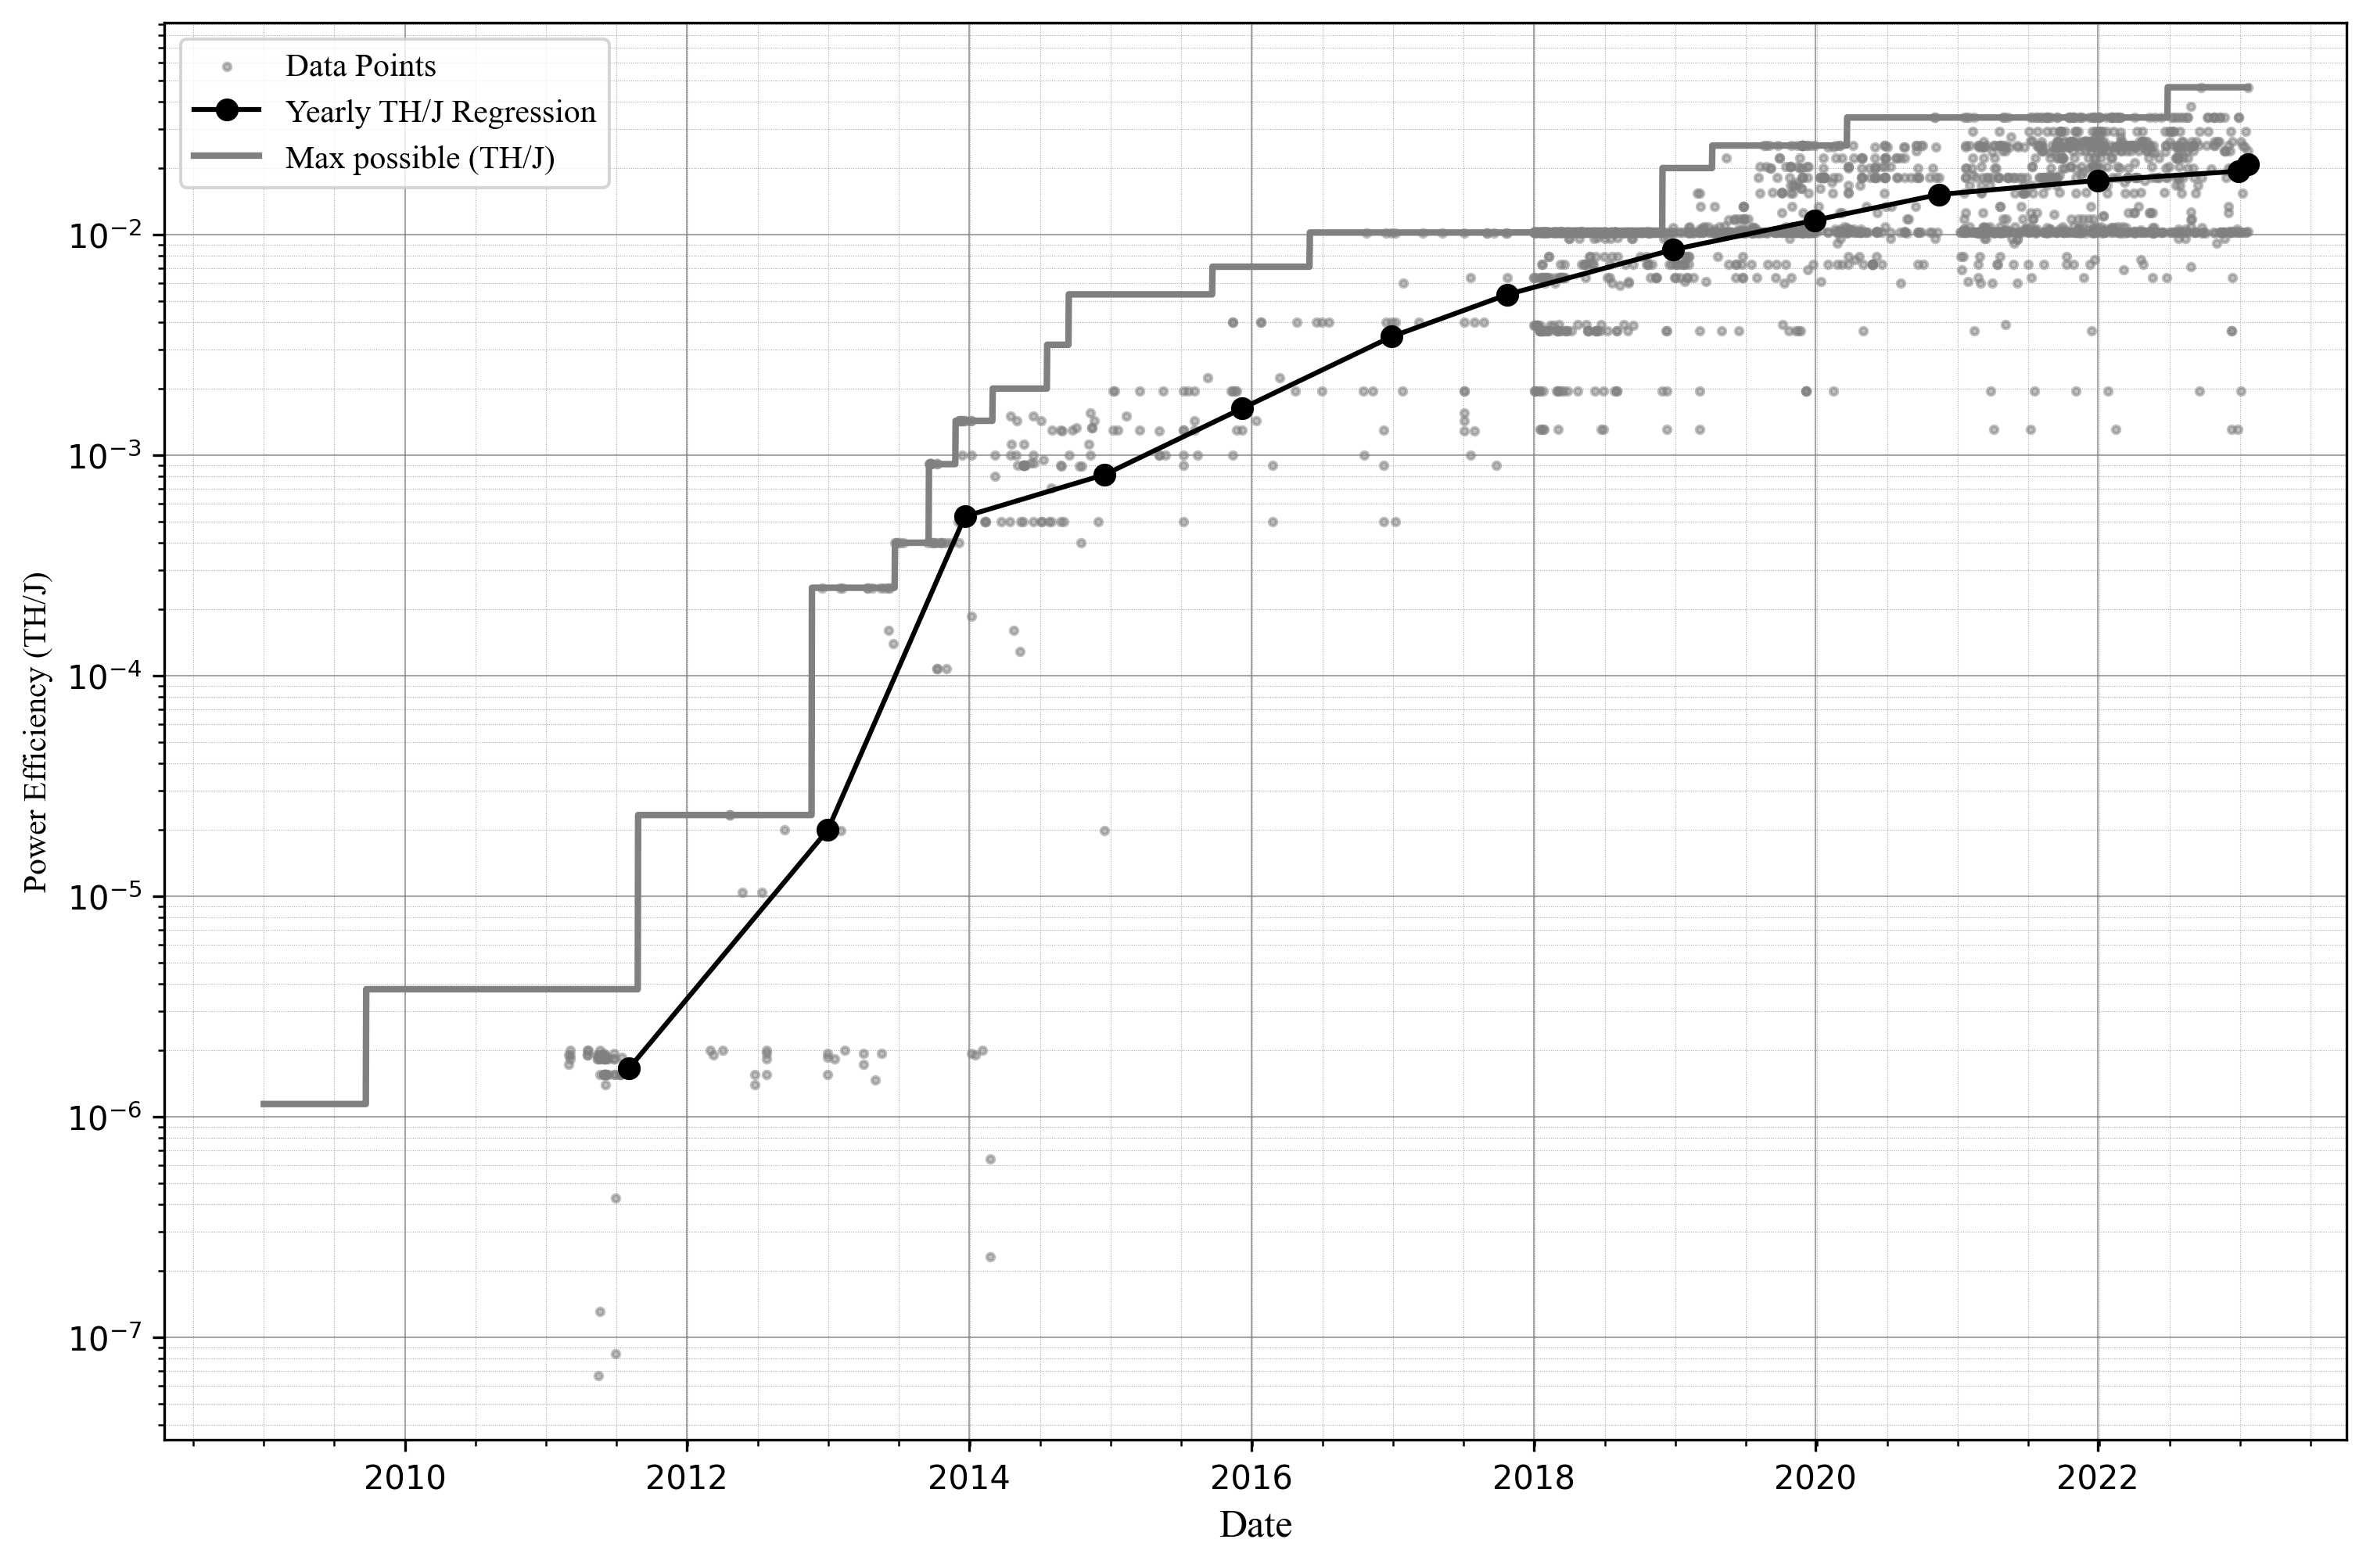

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../hardwarelist/Bitcoin max updated2.csv')

# Assuming the 'Date' column in max_efficiency_table is in a format that can be converted to datetime
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])


data = pd.read_csv('datasets/extracted/final3.csv')
data["date"] = data["date"].apply(lambda x: x[:10])
data2 = pd.read_csv('datasets/extracted/pre_2018.csv')
data = pd.concat([data2[["date","row_index","hardware_name","TH/J"]], data[["date","row_index","hardware_name","TH/J"]]])

def get_max_efficiency(date):
    date = str(date)[:10]
    try:
        return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
    except:
        return -1
    

# delete rows where TH/J is larger than the max efficiency for that date
data['max_efficiency'] = data['date'].apply(lambda x: get_max_efficiency(x))
data = data[data['TH/J'] <= data['max_efficiency']*1.01]

data.to_csv('datasets/extracted/merged.csv', index=False)

# Convert the 'date' column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year from the 'date' column and create a new column 'year'
data['year'] = data['date'].dt.year

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Extract years from the data
years = data['year'].unique()

# Initialize lists to store yearly 'TH/J' values
th_j_values = []

# Create an empty array to store the regression lines
regression_lines = []

# Iterate over each year, calculate the slope, and store the data
for year in years:
    # Filter data for the current year
    yearly_data = data[data['year'] == year]

    # Calculate the mean 'TH/J' value for the year
    th_j_mean = yearly_data[unit_power_efficiency].mean()

    # Store the yearly 'TH/J' value
    th_j_values.append(th_j_mean)

    # Store the regression line for the year (point at the end of the year)
    end_of_year_date = yearly_data['date'].max()
    regression_lines.append((end_of_year_date, th_j_mean))

# Create a DataFrame to store the yearly 'TH/J' values and regression points
results = pd.DataFrame({'Year': years, unit_power_efficiency: th_j_values})

plt.rcParams['font.family'] = 'Times New Roman'

# Scatter plot for all data points
plt.scatter(data['date'], data[unit_power_efficiency], c='gray', s=5, label='Data Points', alpha=0.5)

# Plot the regression lines (one point per year)
regression_dates, regression_th_j_values = zip(*regression_lines)
plt.plot(regression_dates, regression_th_j_values, marker='o', linestyle='-', color='black', label=f'Yearly {unit_power_efficiency} Regression')

# Plot the Hardware (TH/J) line
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)

plt.yscale('log')  # Set the y-axis to a logarithmic scale base 10


plt.xlabel('Date', fontname='Times New Roman', fontsize=12)
plt.ylabel('Power Efficiency (' + unit_power_efficiency + ')', fontname='Times New Roman')
# plt.title(f'Yearly-Updated {unit_power_efficiency} with Data Points and Max Efficiency', fontname='Times New Roman')
plt.legend(loc='upper left')

# Enable minor ticks
plt.minorticks_on()

# Add major grid to the plot
plt.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.7)

# Add minor grid to the plot with a lighter style
plt.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.25, color='gray', alpha=0.7)

plt.yticks()

plt.savefig('high_res_plot.png', dpi=300)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   TH/J   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     479.1
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           6.27e-72
Time:                        20:53:19   Log-Likelihood:                 606.96
No. Observations:                 123   AIC:                            -1204.
Df Residuals:                     118   BIC:                            -1190.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -2.879      0.0

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


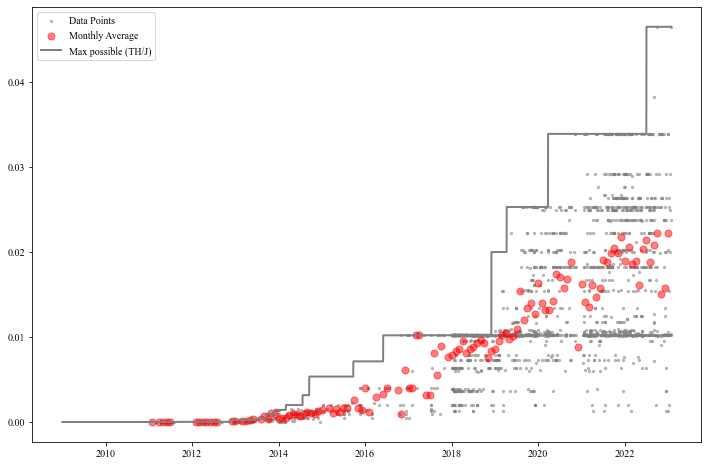

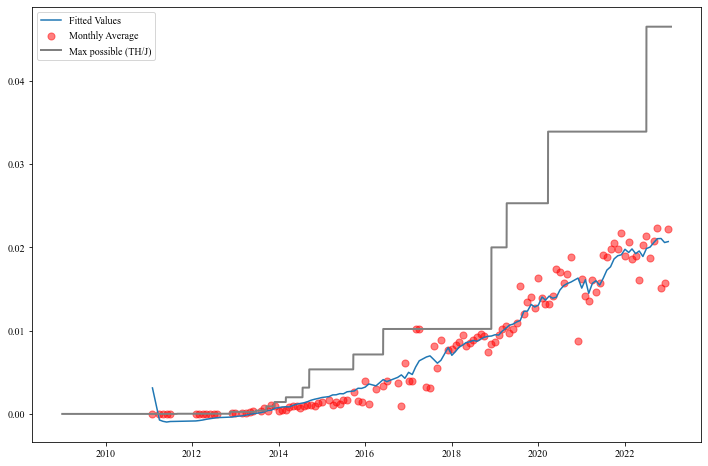

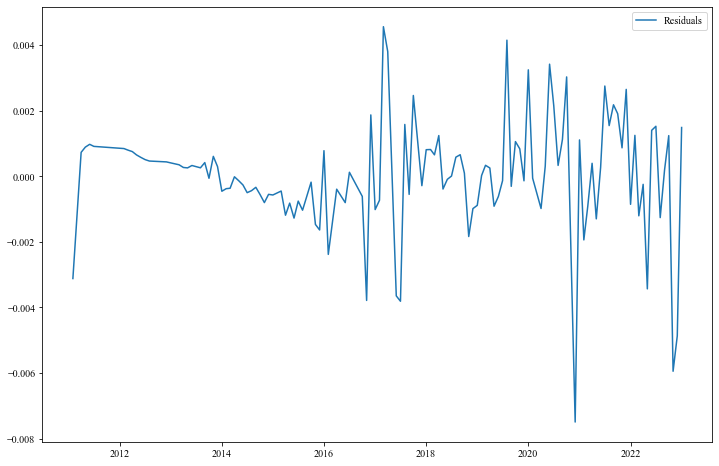

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Assuming 'data' is already loaded and has the 'date' and 'TH/J' columns

# Step 1: Average the data points on a monthly basis
# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')

# Create a 'month' column by offsetting the 'date' by 15 days and then using to_period
data['month'] = (data['date'] - timedelta(days=15)).dt.to_period('M')

# Group by 'month' and calculate the mean of 'TH/J'
monthly_data = data.groupby('month')['TH/J'].mean().reset_index()

# Convert 'month' back to datetime (first day of the month)
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Step 2: Create a time series for power efficiency
# Create the time variable t (in months)
monthly_data['t'] = np.arange(len(monthly_data))

# Then, create t^2
monthly_data['t_squared'] = monthly_data['t'] ** 2

# Get the maximum power efficiency over time
monthly_data['P_max_t'] = monthly_data['month'].apply(lambda x: get_max_efficiency(x))

# Create the AR(l)MA(l) term
# Here, we use the ARIMA model with l=10
# Note: ARIMA requires a univariate time series, so we only pass 'TH/J'
model = ARIMA(monthly_data['TH/J'], order=(10,0,10))
model_fit = model.fit()

# Add the AR(l)MA(l) term to the data
monthly_data['ARMA'] = model_fit.fittedvalues

# Now, we can create the time series for power efficiency
X = monthly_data[['t', 't_squared', 'P_max_t', 'ARMA']]
X = sm.add_constant(X)  # Add a constant term to the predictors
y = monthly_data['TH/J']

# Step 3: Apply the Ordinary Least Squares Method (OLS)
model = sm.OLS(y, X)
results = model.fit()

# Print out the statistics
print(results.summary())

# Step 4: Plot single point for each month + all the data points
plt.figure(figsize=(12, 8))
plt.scatter(data['date'], data[unit_power_efficiency], c='gray', s=5, label='Data Points', alpha=0.5)
plt.scatter(monthly_data['month'], monthly_data['TH/J'], c='red', s=50, label='Monthly Average', alpha=0.5)  # Corrected line
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)
plt.legend()
plt.show()

# Step 5: Plot P_eff,t(t) + Single point for each month
plt.figure(figsize=(12, 8))
plt.plot(monthly_data['month'], results.fittedvalues, label='Fitted Values')
plt.scatter(monthly_data['month'], monthly_data['TH/J'], c='red', s=50, label='Monthly Average', alpha=0.5)  # Corrected line
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)
plt.legend()
plt.show()

# Step 6: Plot with just the residual term
plt.figure(figsize=(12, 8))
plt.plot(monthly_data['month'], results.resid, label='Residuals')
plt.legend()
plt.show()

In [4]:
# looks like:
# [
#  (Timestamp('2011-08-04 00:00:00'), 1.9952745454545455e-06),
#  (Timestamp('2012-12-31 00:00:00'), 3.2042489473684216e-05),
#  (Timestamp('2013-12-21 00:00:00'), 0.0005635879322033898)
# ]
regression_lines

[(Timestamp('2011-08-04 00:00:00'), 1.6507425925925926e-06),
 (Timestamp('2012-12-31 00:00:00'), 1.993373888888889e-05),
 (Timestamp('2013-12-21 00:00:00'), 0.0005265301428571429),
 (Timestamp('2014-12-18 00:00:00'), 0.0008150532636363637),
 (Timestamp('2015-12-09 00:00:00'), 0.0016275294117647058),
 (Timestamp('2016-12-30 00:00:00'), 0.0034413043478260874),
 (Timestamp('2017-10-25 00:00:00'), 0.005338777777777777),
 (Timestamp('2018-12-28 00:00:00'), 0.008530398618197797),
 (Timestamp('2019-12-29 00:00:00'), 0.011590368879310496),
 (Timestamp('2020-11-15 00:00:00'), 0.015165744845454162),
 (Timestamp('2021-12-31 00:00:00'), 0.017573820731262336),
 (Timestamp('2022-12-31 00:00:00'), 0.01934954748481776),
 (Timestamp('2023-01-24 00:00:00'), 0.020778871298524647)]

In [5]:
df = pd.DataFrame(columns=['date', 'max possible', 'archaicity', 'max found', 'regression'])
df['date'] = max_efficiency_table['date']
df['max possible'] = max_efficiency_table['max (TH/J)']
df['archaicity'] = max_efficiency_table['archaicity (TH/J)']


# finds the 2 closest timestamps in regression_lines and returns the interpolated value
def get_regression(date):
    closest_smaller_timestamp_index = None
    closest_larger_timestamp_index = None
    for (i,(timestamp, value)) in enumerate(regression_lines):
        if timestamp <= date:
            closest_smaller_timestamp_index = i
        else:
            closest_larger_timestamp_index = i
            break
    
    if closest_smaller_timestamp_index is None:
        return regression_lines[0][1]
    elif closest_larger_timestamp_index is None:
        return regression_lines[-1][1]
    
    smaller_value = regression_lines[closest_smaller_timestamp_index][1]
    larger_value = regression_lines[closest_larger_timestamp_index][1]

    # interpolate
    return smaller_value + (larger_value - smaller_value) * (date - regression_lines[closest_smaller_timestamp_index][0]) / (regression_lines[closest_larger_timestamp_index][0] - regression_lines[closest_smaller_timestamp_index][0])

     
df['regression'] = df['date'].apply(get_regression)

# gets the max efficiency for a given date from the data table
def get_max_efficiency(date):
    return data[data['date'] == date][unit_power_efficiency].max()

df['max found'] = df['date'].apply(get_max_efficiency)

In [6]:
df.sample(30)

,date,max possible,archaicity,max found,regression
3796,2019-05-25,0.025300,0.020000,0.010204,0.009768
3612,2018-11-22,0.010210,0.010200,NaN,0.008263
4912,2022-06-14,0.033900,0.033900,0.033898,0.018377
4854,2022-04-17,0.033900,0.033900,NaN,0.018094
4335,2020-11-14,0.033900,0.033900,NaN,0.015155
1511,2013-02-20,0.000250,0.000023,NaN,0.000093
4388,2021-01-06,0.033900,0.033900,NaN,0.015470
5078,2022-11-27,0.046500,0.046500,NaN,0.019184
1060,2011-11-27,0.000023,0.000004,NaN,0.000006
2730,2016-06-23,0.010200,0.005350,NaN,0.002551


In [7]:
df.to_csv('plot.csv', index=False)